In [6]:
import math
import numpy as np 
import sub_func_ce
from sub_func_ce import abs_dis, find_overlap
import matplotlib.pyplot as plt
from itertools import combinations, product
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from random import randrange
from IPython.display import clear_output
import os

# %matplotlib widget
%matplotlib inline

def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

def ele_list_gen(cr_c, mn_c, co_c, ni_c, num_c, mode = 'randchoice'):
    np.random.seed()

    assert abs(cr_c + mn_c + co_c + ni_c - 1) < 0.001, 'Make sure atomic ratio sum to 1'

    while True:
        if mode == 'randchoice':
            len_cr = randrange(int(cr_c*num_c),int(cr_c*num_c)+2)
            len_mn = randrange(int(mn_c*num_c),int(mn_c*num_c)+2)
            len_co = randrange(int(co_c*num_c),int(co_c*num_c)+2)
        elif mode == 'int':
            len_cr = int(cr_c*num_c)
            len_mn = int(mn_c*num_c)
            len_co = int(co_c*num_c)
        
        len_ni = num_c-len_cr-len_mn-len_co
        if abs(len_ni-num_c*ni_c) <= 1:
            break

    ele_list_raw = np.concatenate([np.zeros(len_cr)+2,np.ones(len_mn),0-np.ones(len_co),-1-np.ones(len_ni)],axis=0)
    np.random.shuffle(ele_list_raw)
    
    return ele_list_raw

def swap_step(action, state,):

    a1 = action[0]
    a2 = action[1]

    state[a2], state[a1] = state[a1], state[a2]

    return state

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

##### Deduction of configs which are in 3-D periodic boundary condition (PBC).

In [14]:
%matplotlib widget
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')
ind_pbc = ind_raw.copy()
trans_mat = np.array([0,-1,1])
for i, j, k in product(trans_mat, repeat=3):
    trans_vector = np.array([i,j,k])
    if np.linalg.norm(trans_vector) != 0:
        ind_pbc = np.concatenate([ind_pbc, ind_raw+trans_vector], axis=0)

ind_pbc[]

array([[ 0.  ,  0.  , -1.  ],
       [ 0.  ,  0.  , -0.5 ],
       [ 0.  ,  0.25, -0.75],
       [ 0.  ,  0.25, -0.25],
       [ 0.  ,  0.5 , -1.  ],
       [ 0.  ,  0.5 , -0.5 ],
       [ 0.  ,  0.75, -0.75],
       [ 0.  ,  0.75, -0.25],
       [ 0.25,  0.  , -0.75],
       [ 0.25,  0.  , -0.25],
       [ 0.25,  0.25, -1.  ],
       [ 0.25,  0.25, -0.5 ],
       [ 0.25,  0.5 , -0.75],
       [ 0.25,  0.5 , -0.25],
       [ 0.25,  0.75, -1.  ],
       [ 0.25,  0.75, -0.5 ],
       [ 0.5 ,  0.  , -1.  ],
       [ 0.5 ,  0.  , -0.5 ],
       [ 0.5 ,  0.25, -0.75],
       [ 0.5 ,  0.25, -0.25],
       [ 0.5 ,  0.5 , -1.  ],
       [ 0.5 ,  0.5 , -0.5 ],
       [ 0.5 ,  0.75, -0.75],
       [ 0.5 ,  0.75, -0.25],
       [ 0.75,  0.  , -0.75],
       [ 0.75,  0.  , -0.25],
       [ 0.75,  0.25, -1.  ],
       [ 0.75,  0.25, -0.5 ],
       [ 0.75,  0.5 , -0.75],
       [ 0.75,  0.5 , -0.25],
       [ 0.75,  0.75, -1.  ],
       [ 0.75,  0.75, -0.5 ]])

In [12]:
ind_pbc

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 ],
       [0.  , 0.25, 0.25],
       ...,
       [1.75, 1.5 , 1.75],
       [1.75, 1.75, 1.  ],
       [1.75, 1.75, 1.5 ]])

In [25]:
np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw_pbc32.npy', ind_pbc)

In [24]:
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')
pth = '/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/'
len_c = len(ind_pbc)
ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc = [], [], [], []
dis_list = []
for i, j in combinations(range(len_c), 2):
    ind = np.array([i,j])
    if len(np.where(ind < 32)[0]) == 1:
        a1 = ind_pbc[i]
        a2 = ind_pbc[j]
        if abs_dis(a1, a2, nn1) < 0.001:
            ind_1nn_pbc.append([i,j])
        elif abs_dis(a1, a2, nn2) < 0.001:
            ind_2nn_pbc.append([i,j])
        elif abs_dis(a1, a2, nn3) < 0.001:
            ind_3nn_pbc.append([i,j])
        elif abs_dis(a1, a2, nn4) < 0.001:
            ind_4nn_pbc.append([i,j])

np.save(pth+'ind_1nn_pbc', ind_1nn_pbc)
np.save(pth+'ind_2nn_pbc', ind_2nn_pbc)
np.save(pth+'ind_3nn_pbc', ind_3nn_pbc)
np.save(pth+'ind_4nn_pbc', ind_4nn_pbc)

In [ ]:
dis_list = np.sort(np.unique(dis_list))
nn1, nn2, nn3, nn4 = dis_list[:4]

Arrangement:

$\bar\Phi_i = \Gamma(\Phi_i)$

$\bar\Phi_i = \bar\Phi_i(\widehat{T} \circ \vec\sigma)$

$\{\phi_1, ..., \phi_n\} = \bar\Phi_i$

$E(\vec{\sigma})=V_0\Phi_0 + \sum_{n}\sum_{\tau}V_n^{\tau}(T)\bar\Phi_n^{\tau}(\vec{\sigma})^T$

$n$ = Number of cluster in such config.

$V_n =\ <E(\vec{\sigma})|\bar\Phi_n>$ = Weight, from the viewpoint of FFT.

Clusters' symmetry operation:

1. Pair

A = B: ./1

A != B: ./2

2. Trip.

A = B = C: ./1

A = B != C: ./3

A != B != C: ./6

3. Quad.

A = B = C = D: ./1

A = B = C != D: ./4

A = B != C != D: ./8

A != B != C != D: ./8

In [4]:
class CE:
    def __init__(self, ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
                ind_qua1nn, ind_qua1nn2nn,
                ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
                ind_raw):

        self.ind_1nn = ind_1nn
        self.ind_2nn = ind_2nn
        self.ind_3nn = ind_3nn
        self.ind_4nn = ind_4nn
        self.ind_qua1nn = ind_qua1nn
        self.ind_qua1nn2nn = ind_qua1nn2nn
        self.ind_trip1nn = ind_trip1nn
        self.ind_trip1nn2nn = ind_trip1nn2nn
        self.ind_trip1nn2nn3nn = ind_trip1nn2nn3nn
        self.ind_raw = ind_raw
        self.sym_oplist = np.array([2, 1, 1, 0, 6, 0, 4, 12, 24])
        self.sym_optri = np.array([6, 3, 1])
        self.sym_opqua = np.array([0, 0, 1, 0, 0, 0, 2, 0, 4])

    #*Normalizaiton by the symmetry operation for each cluster
    def sym_operator(self, cluster, mode='None'):
        if mode == 'None':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_oplist[mode_sym+mode_cluster-2]

        if mode == 'tri1nn':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_optri[mode_sym]
        
        if mode == 'qua1nn':
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            sym_op = self.sym_oplist[c_ind]

        if mode == 'qua1nn2nn':
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            single_list = np.array([2, 6, 8])
            if c_ind in single_list:
                sym_op = self.sym_opqua[c_ind]
            else:
                if c_ind == 4:
                    if len(np.unique(cluster[:2])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 1

                elif c_ind == 7:
                    if len(np.unique(cluster[:2])) == 2 and len(np.unique(cluster[2:4])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 2

        return sym_op

    def phi1(self, x):
        return 2/math.sqrt(10)*x

    def phi2(self, x):
        return -5/3 + 2/3*(x**2)

    def phi3(self, x):
        return -17/30*math.sqrt(10)*x + math.sqrt(10)/6*(x**3)
    
    #*Return the correlation function for each cluster
    def cpr(self, val_list):
        p1l = self.phi1(val_list).reshape(-1, 1)
        p2l = self.phi2(val_list).reshape(-1, 1)
        p3l = self.phi3(val_list).reshape(-1, 1)
        pl = np.concatenate([p1l, p2l, p3l], 1).T
        c_len = len(val_list)
        atom = 1
        for i in range(c_len):
            atom_1 = pl[:, i]
            atom = np.outer(atom_1, atom)

        return atom.flatten()

    def cluster_extra(self, config):
        cpr_1nn = 0
        for i in self.ind_1nn:
            a1, a2 = config[i[0]], config[i[1]]
            #* Extra a single cluster within that specie
            cluster = np.array([a1, a2])
            cpr_1nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_2nn = 0
        for i in self.ind_2nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_2nn += self.cpr(cluster)/self.sym_operator(cluster)
        
        cpr_3nn = 0
        for i in self.ind_3nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_3nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_4nn = 0
        for i in self.ind_4nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_4nn += self.cpr(cluster)/self.sym_operator(cluster)
            
        cpr_tri1nn = 0
        for i in self.ind_trip1nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')

        cpr_tri1nn2nn = 0
        for i in self.ind_trip1nn2nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            #*The only operation in this case when in AAB form
            if (a1 == a2 and a1 != a3) or (a1 == a3 and a1 != a2):
                cpr_tri1nn2nn += self.cpr(cluster)/2
            else:
                cpr_tri1nn2nn += self.cpr(cluster)

        cpr_tri1nn2nn3nn = 0
        for i in self.ind_trip1nn2nn3nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn2nn3nn += self.cpr(cluster)

        #!Consider the operation in qua later
        cpr_qua1nn = 0
        for i in self.ind_qua1nn:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn')

        cpr_qua1nn2nn = 0
        for i in self.ind_qua1nn2nn:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn2nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn2nn')

        return np.concatenate([
            cpr_1nn, cpr_2nn, cpr_3nn, cpr_4nn,
            cpr_tri1nn, cpr_tri1nn2nn, cpr_tri1nn2nn3nn,
            cpr_qua1nn, 
            # np.ones(1)
        ], 0) #*Remove a quadruplet term

    def config_extra(self, num_cell, ind_cr, ind_mn, ind_co, ind_ni):
        ele_list = np.zeros(num_cell)
        overlap_cr = find_overlap(self.ind_raw, ind_cr)
        overlap_mn = find_overlap(self.ind_raw, ind_mn)
        overlap_co = find_overlap(self.ind_raw, ind_co)
        overlap_ni = find_overlap(self.ind_raw, ind_ni)

        ele_list[np.where(overlap_cr)[0]] = 2
        ele_list[np.where(overlap_mn)[0]] = 1
        ele_list[np.where(overlap_co)[0]] = -1
        ele_list[np.where(overlap_ni)[0]] = -2

        cpr_list = self.cluster_extra(ele_list)

        return cpr_list

    def read(self, incar_dir):
        with open(incar_dir) as f:
            input_strip = [s.strip() for s in f.readlines()]
        return input_strip

In [11]:
#* Deducing step

ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn.npy')
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')

weight_list, energy = [], []
ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_qua1nn2nn,
        ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_raw)
for i in range(1, 73):
    if i!=50:
        ind_cr = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_cr_chosen.npy')
        ind_mn = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_mn_chosen.npy')
        ind_co = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_co_chosen.npy')
        ind_ni = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_ni_chosen.npy')
        osz_dir = f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Cr25Mn25Co25Ni25_3.512_try{i}/OSZICAR'
        oszicar = ce_.read(osz_dir)[-1]
        e_ground = float(''.join(oszicar).split()[-4])
        ce_feature = ce_.config_extra(32, ind_cr, ind_mn, ind_co, ind_ni)
        weight_list.append(ce_feature)
        energy.append(e_ground)

weight_list, energy = np.array(weight_list), np.array(energy)
e_train, e_test, weight_train, weight_test = train_test_split(energy, weight_list, test_size=0.2)
n_weights_ = weight_train.shape[0]
clf_ = RidgeCV().fit(weight_train, e_train)
print(clf_.score(weight_train, e_train))
coef_ = clf_.coef_

0.9999808178364704


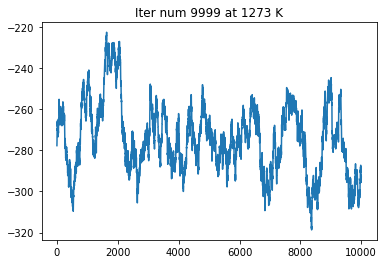

In [17]:
#* Estimation step
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn3nn.npy')
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_raw2048.npy')

ce_e = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_qua1nn2nn,
        ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_raw)

config = ele_list_gen(1/4, 1/4, 1/4, 1/4, num_c=2048)
iter_time= 10000
temp = 1273
k_ = 8.617333262e-5
e_list = []
config_list = np.zeros((50, 2048))
e_list_store = np.zeros(50)
for i in range(iter_time):
        weight_config = ce_e.cluster_extra(config).reshape(-1,1).T
        energy = clf_.predict(weight_config)
        e_list.append(energy)
        config_list[iter_time%50] = config
        e_list_store[iter_time%50] = energy

        a_ind = randrange(len(ind_1nn))
        action = ind_1nn[a_ind]
        config_ = swap_step(action, config)
        weight_config_ = ce_e.cluster_extra(config_).reshape(-1,1).T
        energy_ = clf_.predict(weight_config_)

        accept = np.min([1, np.exp((energy-energy_)/(k_*temp))])
        r_v = np.random.rand()
        if r_v <= accept:
                config = config_
        else:
                config = config

        clear_output(True)
        plt.title(f'Iter num {i} at {temp} K')
        plt.plot(e_list)
        plt.show()

In [15]:
np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/CE/2048_qua/273/config', config_list)
np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/CE/2048_qua/273/energy', e_list)

In [196]:
clf_.predict(weight_test)

array([-247.60429228, -247.39531867, -248.81587907, -248.34429353,
       -249.09029811, -248.82051696, -248.96710965, -245.77977474,
       -249.21112519, -248.0147978 , -246.99721478, -250.96710612,
       -246.67043486])

In [201]:
ce_e.cluster_extra(config).reshape(-1,1).T.shapen_weights_

(1, 279)

In [31]:
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')

1. Triplets

In [26]:
ind_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw_pbc32.npy')
# ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')
pth = '/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/'
len_c = len(ind_pbc)
ind_trip1nn_pbc, ind_trip1nn2nn_pbc, ind_trip1nn2nn3nn_pbc = [], [], []

ideal_1nn = np.array([nn1, nn1, nn1])
ideal_1nn2nn = np.array([nn1, nn1, nn2])
ideal_1nn2nn3nn = np.array([nn1, nn2, nn3])
short_path = np.array([nn1, nn1])

for i, j, k in combinations(range(len_c), 3):
    ind = np.array([i, j, k])
    if 1 <= len(np.where(ind < 32)[0]) <= 2:
        a1 = ind_pbc[i]
        a2 = ind_pbc[j]
        a3 = ind_pbc[k]
        dis1 = abs_dis(a1, a2, 0)
        dis2 = abs_dis(a1, a3, 0)
        dis3 = abs_dis(a2, a3, 0)
        
        if np.linalg.norm(np.sort([dis1, dis2, dis3]) - ideal_1nn) < 0.001:
            ind_trip1nn_pbc.append([i,j,k])
        
        elif np.linalg.norm(np.sort([dis1, dis2, dis3])-ideal_1nn2nn) < 0.001:
            if np.linalg.norm(np.sort([dis1, dis2])-short_path) < 0.001:
                ind_trip1nn2nn_pbc.append([i, j, k])
            elif np.linalg.norm(np.sort([dis1, dis3])-short_path) < 0.001:
                ind_trip1nn2nn_pbc.append([j, i, k])
            elif np.linalg.norm(np.sort([dis2, dis3])-short_path) < 0.001:
                ind_trip1nn2nn_pbc.append([k, i, j])

        elif np.linalg.norm(np.sort([dis1, dis2, dis3])-ideal_1nn2nn3nn) < 0.001:
            ind_trip1nn2nn3nn_pbc.append([i,j,k])

np.save(pth+'ind_trip1nn_pbc', ind_trip1nn_pbc)
np.save(pth+'ind_trip1nn2nn_pbc', ind_trip1nn2nn_pbc)
np.save(pth+'ind_trip1nn2nn3nn_pbc', ind_trip1nn2nn3nn_pbc)

In [39]:
#*a, b, c = 1nn, 1nn, 1nn
ind_trip1nn = []
for i, j, k in combinations(range(len(ind_raw)), 3):
    a1 = ind_raw[i]
    a2 = ind_raw[j]
    a3 = ind_raw[k]
    dis1 = abs_dis(a1, a2, nn1)
    dis2 = abs_dis(a1, a3, nn1)
    dis3 = abs_dis(a2, a3, nn1)
    if np.linalg.norm([dis1, dis2, dis3]) < 0.001:
        ind_trip1nn.append([i, j, k])

np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn', ind_trip1nn)
len(ind_trip1nn)

108

In [15]:
#*a, b, c = 1nn, 1nn, 2nn
nn1, nn2 = dis_list[:2]
ind_trip1nn = []
ideal_len = np.array([nn1, nn1, nn2])
short_path = np.array([nn1, nn1])
for i, j, k in combinations(range(len(ind_raw)), 3):
    a1 = ind_raw[i]
    a2 = ind_raw[j]
    a3 = ind_raw[k]
    dis1 = abs_dis(a1, a2, 0)
    dis2 = abs_dis(a1, a3, 0)
    dis3 = abs_dis(a2, a3, 0)
    
    if np.linalg.norm(np.sort([dis1, dis2, dis3])-ideal_len) < 0.001:
        if np.linalg.norm(np.sort([dis1, dis2])-short_path) < 0.001:
            ind_trip1nn.append([i, j, k])
        elif np.linalg.norm(np.sort([dis1, dis3])-short_path) < 0.001:
            ind_trip1nn.append([j, i, k])
        elif np.linalg.norm(np.sort([dis2, dis3])-short_path) < 0.001:
            ind_trip1nn.append([k, i, j])

np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn', ind_trip1nn)
len(ind_trip1nn)

144

In [41]:
#*a, b, c = 1nn, 2nn, 3nn
ind_trip1nn = []
ideal_len = np.array([nn1, nn2, nn3])
for i, j, k in combinations(range(len(ind_raw)), 3):
    a1 = ind_raw[i]
    a2 = ind_raw[j]
    a3 = ind_raw[k]
    dis1 = abs_dis(a1, a2, 0)
    dis2 = abs_dis(a1, a3, 0)
    dis3 = abs_dis(a2, a3, 0)
    if np.linalg.norm(np.sort([dis1, dis2, dis3])-ideal_len) < 0.001:
        ind_trip1nn.append([i, j, k])

np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn', ind_trip1nn)
len(ind_trip1nn)

216

2. Quadruplets

In [29]:
ind_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw_pbc32.npy')
# ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')
pth = '/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/'
len_c = len(ind_pbc)
ind_qua1nn_pbc = []

ideal_1nn = np.array([nn1, nn1, nn1, nn1, nn1, nn1])

for i, j, k, l in combinations(range(len_c), 4):
    ind = np.array([i, j, k, l])
    if 1 <= len(np.where(ind < 32)[0]) <= 3:
        a1 = ind_pbc[i]
        a2 = ind_pbc[j]
        a3 = ind_pbc[k]
        a4 = ind_pbc[l]

        dis1 = abs_dis(a1, a2, 0)
        dis2 = abs_dis(a1, a3, 0)
        dis3 = abs_dis(a1, a4, 0)
        dis4 = abs_dis(a2, a3, 0)
        dis5 = abs_dis(a2, a4, 0)
        dis6 = abs_dis(a3, a4, 0)

        if np.linalg.norm(np.sort([dis1, dis2, dis3, dis4, dis5, dis6])-ideal_1nn) < 0.001:
            ind_qua1nn_pbc.append([i, j, k, l])

np.save(pth+'ind_qua1nn_pbc', ind_qua1nn_pbc)

In [45]:
#*a, b, c, d, e, f = 1nn, 1nn, 1nn, 1nn, 1nn, 2nn
ind_qua1nn = []
ideal_len = np.array([nn1, nn1, nn1, nn1, nn1, nn1])
for i, j, k, l in combinations(range(len(ind_raw)), 4):
    a1 = ind_raw[i]
    a2 = ind_raw[j]
    a3 = ind_raw[k]
    a4 = ind_raw[l]
    dis1 = abs_dis(a1, a2, 0)
    dis2 = abs_dis(a1, a3, 0)
    dis3 = abs_dis(a1, a4, 0)
    dis4 = abs_dis(a2, a3, 0)
    dis5 = abs_dis(a2, a4, 0)
    dis6 = abs_dis(a3, a4, 0)
    if np.linalg.norm(np.sort([dis1, dis2, dis3, dis4, dis5, dis6])-ideal_len) < 0.001:
        ind_qua1nn.append([i, j, k, l])

np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn', ind_trip1nn)
len(ind_qua1nn)

27

In [27]:
#*a, b, c, d = 1nn, 1nn, 1nn, 1nn
ind_qua1nn = []
ideal_len = np.array([nn1, nn1, nn1, nn1, nn1, nn2])
for i, j, k, l in combinations(range(len(ind_raw)), 4):
    a1 = ind_raw[i]
    a2 = ind_raw[j]
    a3 = ind_raw[k]
    a4 = ind_raw[l]
    dis1 = abs_dis(a1, a2, 0)
    dis2 = abs_dis(a1, a3, 0)
    dis3 = abs_dis(a1, a4, 0)
    dis4 = abs_dis(a2, a3, 0)
    dis5 = abs_dis(a2, a4, 0)
    dis6 = abs_dis(a3, a4, 0)
    if np.linalg.norm(np.sort([dis1, dis2, dis3, dis4, dis5, dis6])-ideal_len) < 0.001:
        if dis1 == nn2:
            ind_qua1nn.append([i, j, k, l])
        elif dis2 == nn2:
            ind_qua1nn.append([i, k, j, l])
        elif dis3 == nn2:
            ind_qua1nn.append([i, l, k, j])
        elif dis4 == nn2:
            ind_qua1nn.append([k, j, i, l])
        elif dis5 == nn2:
            ind_qua1nn.append([l, j, k, i])
        elif dis6 == nn2:
            ind_qua1nn.append([k, l, i, j])

np.save('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn', ind_qua1nn)
len(ind_qua1nn)

108